# TCR clonality analysis

In [1]:
import sys

import scirpy as ir
import scanpy as sc
from glob import glob
import pandas as pd
import tarfile
import anndata
import warnings
import joblib
import scipy as sp
import numpy as np

import matplotlib.pyplot as plt

In [2]:
sys.path.append('/home/gokcen/Code/sctoolkit/')

In [3]:
from sctoolkit.utils import run_spring, dotplot_spring, bin_pval
from sctoolkit.proportions import plot_proportion_barplot

In [4]:
sc.set_figure_params(dpi=90)

In [5]:
ir.__version__

'0.5.0'

## Load adatas

In [5]:
ad1 = sc.read('mgh-105-cells-with-IR-20210422-v2.h5ad')
ad2 = sc.read('mgh-106-cells-with-IR-20210422.h5ad')

In [6]:
ad1_raw = sc.read('jovian/outputs/anndata/adata-sample-MGH105.h5ad')
ad2_raw = sc.read('jovian/outputs/anndata/adata-sample-MGH106.h5ad')

In [7]:
ad1_raw = ad1_raw[ad1.obs.index].copy()
ad2_raw = ad2_raw[ad2.obs.index].copy()

ad1_raw.obs = ad1.obs
ad2_raw.obs = ad2.obs

ad1 = ad1_raw
ad2 = ad2_raw

In [8]:
ad1

AnnData object with n_obs × n_vars = 678 × 22264
    obs: '10x_cell_calling', 'sample_name', 'raw', 'empty_drops_FDR', 'neg_log10_empty_drops_FDR', 'n_umis', 'n_genes', 'log10_n_umis', 'log10_n_genes', 'barcode_rank', 'mt_frac', 'n_counts', 'scrublet', 'scrublet_score', 'predicted_sex', 'S_score', 'G2M_score', 'phase', 'leiden', 'IR_VJ_1_locus', 'IR_VJ_2_locus', 'IR_VDJ_1_locus', 'IR_VDJ_2_locus', 'IR_VJ_1_cdr3', 'IR_VJ_2_cdr3', 'IR_VDJ_1_cdr3', 'IR_VDJ_2_cdr3', 'IR_VJ_1_cdr3_nt', 'IR_VJ_2_cdr3_nt', 'IR_VDJ_1_cdr3_nt', 'IR_VDJ_2_cdr3_nt', 'IR_VJ_1_expr', 'IR_VJ_2_expr', 'IR_VDJ_1_expr', 'IR_VDJ_2_expr', 'IR_VJ_1_expr_raw', 'IR_VJ_2_expr_raw', 'IR_VDJ_1_expr_raw', 'IR_VDJ_2_expr_raw', 'IR_VJ_1_v_gene', 'IR_VJ_2_v_gene', 'IR_VDJ_1_v_gene', 'IR_VDJ_2_v_gene', 'IR_VJ_1_d_gene', 'IR_VJ_2_d_gene', 'IR_VDJ_1_d_gene', 'IR_VDJ_2_d_gene', 'IR_VJ_1_j_gene', 'IR_VJ_2_j_gene', 'IR_VDJ_1_j_gene', 'IR_VDJ_2_j_gene', 'IR_VJ_1_c_gene', 'IR_VJ_2_c_gene', 'IR_VDJ_1_c_gene', 'IR_VDJ_2_c_gene', 'IR_VJ_1_ju

In [9]:
ad2

AnnData object with n_obs × n_vars = 460 × 22193
    obs: '10x_cell_calling', 'sample_name', 'raw', 'empty_drops_FDR', 'neg_log10_empty_drops_FDR', 'n_umis', 'n_genes', 'log10_n_umis', 'log10_n_genes', 'barcode_rank', 'mt_frac', 'n_counts', 'scrublet', 'scrublet_score', 'predicted_sex', 'S_score', 'G2M_score', 'phase', 'leiden', 'IR_VJ_1_locus', 'IR_VJ_2_locus', 'IR_VDJ_1_locus', 'IR_VDJ_2_locus', 'IR_VJ_1_cdr3', 'IR_VJ_2_cdr3', 'IR_VDJ_1_cdr3', 'IR_VDJ_2_cdr3', 'IR_VJ_1_cdr3_nt', 'IR_VJ_2_cdr3_nt', 'IR_VDJ_1_cdr3_nt', 'IR_VDJ_2_cdr3_nt', 'IR_VJ_1_expr', 'IR_VJ_2_expr', 'IR_VDJ_1_expr', 'IR_VDJ_2_expr', 'IR_VJ_1_expr_raw', 'IR_VJ_2_expr_raw', 'IR_VDJ_1_expr_raw', 'IR_VDJ_2_expr_raw', 'IR_VJ_1_v_gene', 'IR_VJ_2_v_gene', 'IR_VDJ_1_v_gene', 'IR_VDJ_2_v_gene', 'IR_VJ_1_d_gene', 'IR_VJ_2_d_gene', 'IR_VDJ_1_d_gene', 'IR_VDJ_2_d_gene', 'IR_VJ_1_j_gene', 'IR_VJ_2_j_gene', 'IR_VDJ_1_j_gene', 'IR_VDJ_2_j_gene', 'IR_VJ_1_c_gene', 'IR_VJ_2_c_gene', 'IR_VDJ_1_c_gene', 'IR_VDJ_2_c_gene', 'IR_VJ_1_ju

In [10]:
ad1.obs['Cell type granular'] = ad1.obs.prediction

In [13]:
ad = sc.concat([ad1, ad2], join='outer', label='ind_id', keys=['MGH105', 'MGH106'], index_unique='-')
ad

AnnData object with n_obs × n_vars = 1138 × 23975
    obs: '10x_cell_calling', 'sample_name', 'raw', 'empty_drops_FDR', 'neg_log10_empty_drops_FDR', 'n_umis', 'n_genes', 'log10_n_umis', 'log10_n_genes', 'barcode_rank', 'mt_frac', 'n_counts', 'scrublet', 'scrublet_score', 'predicted_sex', 'S_score', 'G2M_score', 'phase', 'leiden', 'IR_VJ_1_locus', 'IR_VJ_2_locus', 'IR_VDJ_1_locus', 'IR_VDJ_2_locus', 'IR_VJ_1_cdr3', 'IR_VJ_2_cdr3', 'IR_VDJ_1_cdr3', 'IR_VDJ_2_cdr3', 'IR_VJ_1_cdr3_nt', 'IR_VJ_2_cdr3_nt', 'IR_VDJ_1_cdr3_nt', 'IR_VDJ_2_cdr3_nt', 'IR_VJ_1_expr', 'IR_VJ_2_expr', 'IR_VDJ_1_expr', 'IR_VDJ_2_expr', 'IR_VJ_1_expr_raw', 'IR_VJ_2_expr_raw', 'IR_VDJ_1_expr_raw', 'IR_VDJ_2_expr_raw', 'IR_VJ_1_v_gene', 'IR_VJ_2_v_gene', 'IR_VDJ_1_v_gene', 'IR_VDJ_2_v_gene', 'IR_VJ_1_d_gene', 'IR_VJ_2_d_gene', 'IR_VDJ_1_d_gene', 'IR_VDJ_2_d_gene', 'IR_VJ_1_j_gene', 'IR_VJ_2_j_gene', 'IR_VDJ_1_j_gene', 'IR_VDJ_2_j_gene', 'IR_VJ_1_c_gene', 'IR_VJ_2_c_gene', 'IR_VDJ_1_c_gene', 'IR_VDJ_2_c_gene', 'IR_VJ_1_j

In [15]:
assert np.all(ad.layers['counts'].data == ad.layers['counts'].data.round()), 'Not raw counts...'

In [16]:
del ad.obsm['X_diffmap']

In [17]:
ad.X = ad.layers['counts'].copy()

In [18]:
sc.pp.normalize_total(ad, target_sum=10000)
sc.pp.log1p(ad)

sc.pp.highly_variable_genes(ad, n_top_genes=2000, flavor='seurat_v3', layer='counts')

In [19]:
sc.pp.pca(ad)

In [20]:
from harmony import harmonize

In [21]:
ad.obsm['X_harmony'] = harmonize(ad.obsm['X_pca'], ad.obs, 'ind_id')

	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
Reach convergence after 2 iteration(s).


In [22]:
sc.pp.neighbors(ad, n_neighbors=15, use_rep='X_harmony')
sc.tl.umap(ad)
sc.tl.leiden(ad)

In [23]:
ad.obs['scrublet'] = ad.obs['scrublet'].astype(str)

... storing 'sample_name' as categorical
... storing 'scrublet' as categorical
... storing 'IR_VJ_1_cdr3' as categorical
... storing 'IR_VJ_2_cdr3' as categorical
... storing 'IR_VDJ_1_cdr3' as categorical
... storing 'IR_VDJ_2_cdr3' as categorical
... storing 'IR_VJ_1_cdr3_nt' as categorical
... storing 'IR_VJ_2_cdr3_nt' as categorical
... storing 'IR_VDJ_1_cdr3_nt' as categorical
... storing 'IR_VDJ_2_cdr3_nt' as categorical
... storing 'IR_VJ_1_v_gene' as categorical
... storing 'IR_VJ_2_v_gene' as categorical
... storing 'IR_VDJ_1_v_gene' as categorical
... storing 'IR_VDJ_2_v_gene' as categorical
... storing 'IR_VJ_1_j_gene' as categorical
... storing 'IR_VJ_2_j_gene' as categorical
... storing 'IR_VDJ_2_j_gene' as categorical
... storing 'multi_chain' as categorical
... storing 'prediction' as categorical
... storing 'Cell type granular' as categorical


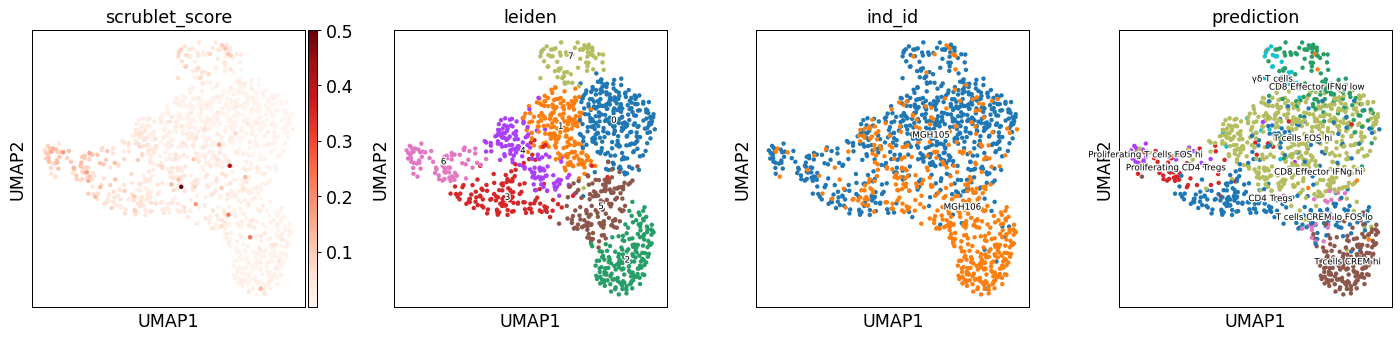

In [24]:
sc.pl.umap(ad, color=['scrublet_score', 'leiden', 'ind_id', 'prediction'], cmap='Reds', vmax=0.5, legend_loc='on data', size=50, legend_fontoutline=2, legend_fontsize=7, legend_fontweight='normal')

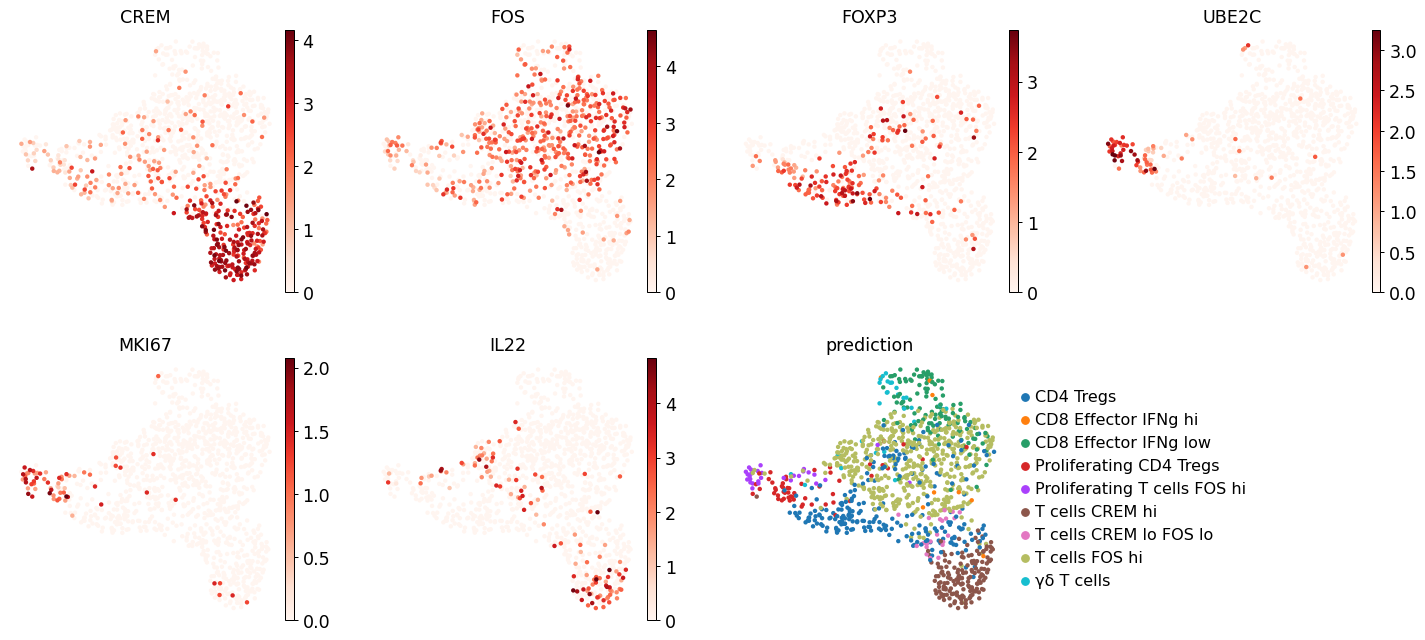

In [26]:
sc.pl.umap(ad, color=['CREM', 'FOS', 'FOXP3', 'UBE2C', 'MKI67', 'IL22', 'ind_id', 'prediction'], cmap='Reds', size=50, frameon=False)

del ad.uns['prediction_colors']

In [27]:
ad

AnnData object with n_obs × n_vars = 1138 × 23975
    obs: '10x_cell_calling', 'sample_name', 'raw', 'empty_drops_FDR', 'neg_log10_empty_drops_FDR', 'n_umis', 'n_genes', 'log10_n_umis', 'log10_n_genes', 'barcode_rank', 'mt_frac', 'n_counts', 'scrublet', 'scrublet_score', 'predicted_sex', 'S_score', 'G2M_score', 'phase', 'leiden', 'IR_VJ_1_locus', 'IR_VJ_2_locus', 'IR_VDJ_1_locus', 'IR_VDJ_2_locus', 'IR_VJ_1_cdr3', 'IR_VJ_2_cdr3', 'IR_VDJ_1_cdr3', 'IR_VDJ_2_cdr3', 'IR_VJ_1_cdr3_nt', 'IR_VJ_2_cdr3_nt', 'IR_VDJ_1_cdr3_nt', 'IR_VDJ_2_cdr3_nt', 'IR_VJ_1_expr', 'IR_VJ_2_expr', 'IR_VDJ_1_expr', 'IR_VDJ_2_expr', 'IR_VJ_1_expr_raw', 'IR_VJ_2_expr_raw', 'IR_VDJ_1_expr_raw', 'IR_VDJ_2_expr_raw', 'IR_VJ_1_v_gene', 'IR_VJ_2_v_gene', 'IR_VDJ_1_v_gene', 'IR_VDJ_2_v_gene', 'IR_VJ_1_d_gene', 'IR_VJ_2_d_gene', 'IR_VDJ_1_d_gene', 'IR_VDJ_2_d_gene', 'IR_VJ_1_j_gene', 'IR_VJ_2_j_gene', 'IR_VDJ_1_j_gene', 'IR_VDJ_2_j_gene', 'IR_VJ_1_c_gene', 'IR_VJ_2_c_gene', 'IR_VDJ_1_c_gene', 'IR_VDJ_2_c_gene', 'IR_VJ_1_j

In [29]:
ad.write('tcr-integrated.h5ad')

In [6]:
ad = sc.read('tcr-integrated.h5ad')

In [7]:
lym = sc.read('../Lymphocytes.h5ad')
lym

AnnData object with n_obs × n_vars = 26944 × 29991
    obs: '10x_cell_calling', 'G2M_score', 'S_score', 'barcode_rank', 'batch', 'chemistry_10x', 'disease_status', 'empty_drops_FDR', 'ind_id', 'leiden', 'leiden_0_4_8', 'leiden_10_14', 'leiden_12', 'leiden_7', 'leiden_9', 'leiden_R', 'lesional', 'log10_n_genes', 'log10_n_umis', 'mito_cutoff_', 'mt_frac', 'n_counts', 'n_genes', 'n_umis', 'neg_log10_empty_drops_FDR', 'phase', 'predicted_cell_types', 'predicted_sex', 'raw', 'sample_name', 'scrublet', 'scrublet_score', 'sex', 'barcode', 'id', 'cellstate', 'disease_lesional', 'healthy678_sanitycheck_activatedtcell', 'healthy125_sanitycheck_activatedtcell', 'healthy125_sanitycheck_activatedtreg', 'healthy678_sanitycheck_activatedtreg', 'leiden_NK', 'leiden_subcluster', 'cellstate_new', 'Cell states', 'leiden_harmony', 'effector_score', 'Cell states v2', 'ind_sample', 'channel', 'Cell type granular'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatch

In [ ]:
sc.pl.umap(lym, color='Cell states v2')

In [9]:
lym = lym[lym.obs['Cell states v2'].isin(ad.obs.prediction.cat.categories)].copy()

In [ ]:
sc.pl.umap(lym, color='Cell states v2')

In [250]:
color_dict = {s: c for c, s in zip(lym.uns['Cell states v2_colors'], lym.obs['Cell states v2'].cat.categories)}

In [251]:
ad.obs.prediction.cat.reorder_categories(lym.obs['Cell states v2'].cat.categories, inplace=True)

In [252]:
ad.uns['prediction_colors'] = [color_dict[x] for x in ad.obs.prediction.cat.categories]

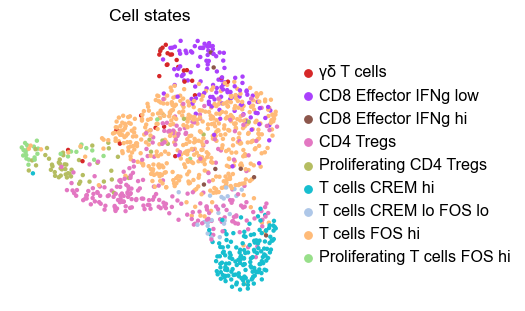

In [253]:
sc.pl.umap(ad, color='prediction', size=50, frameon=False, title='Cell states', save='-cellstates.pdf')

In [ ]:
sc.pl.umap(ad, color=['has_ir', 'CD3E', 'leiden', 'prediction', 'UBE2C', 'MKI67', 'TOP2A', 'IL13', 'IL22', 'NKG7', 'GNLY', 'MB', 'IFNG'], cmap='Reds', size=50, legend_fontoutline=2, legend_fontsize=8, legend_fontweight='normal', legend_loc='on data', frameon=False)

In [15]:
ad._inplace_subset_var(~(ad.var_names.str.startswith('RPL') | ad.var_names.str.startswith('RPS')| ad.var_names.str.startswith('MTRNR')| ad.var_names.str.startswith('RP4')))

In [22]:
sdf = run_spring(ad, 'prediction');

/home/gokcen/.miniconda/lib/python3.8/site-packages/scrublet/helper_functions.py:175: RuntimeWarning: divide by zero encountered in true_divide


  0%|          | 0/9 [00:00<?, ?it/s]

In [23]:
markers = sdf.loc[sdf.groupby('group').spring_score.head(5).index].names.unique()

In [24]:
ad.obs = ad.obs.merge(ad.obs.groupby(['ind_id', 'prediction']).size().reset_index().rename(columns={0: 'predcounts'}), how='left').set_index(ad.obs.index)

In [25]:
temp = ad[ad.obs.predcounts>5].copy()

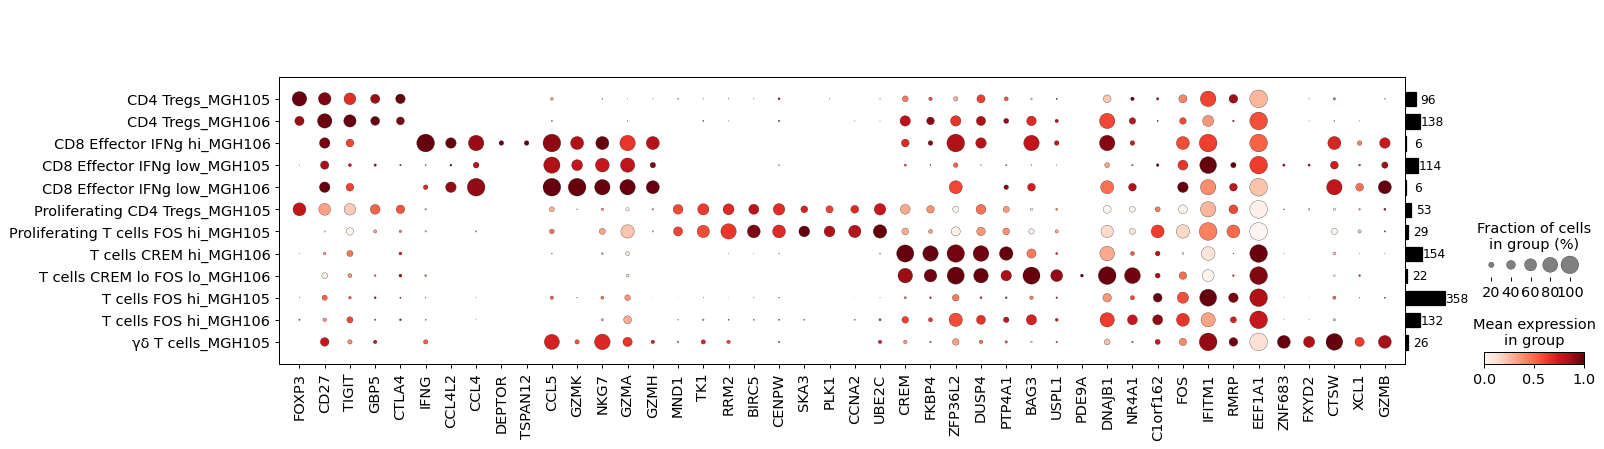

In [26]:
f = sc.pl.dotplot(temp, markers, groupby=['prediction', 'ind_id'], mean_only_expressed=True, standard_scale='var', return_fig=True).add_totals(color='black')
f.show()

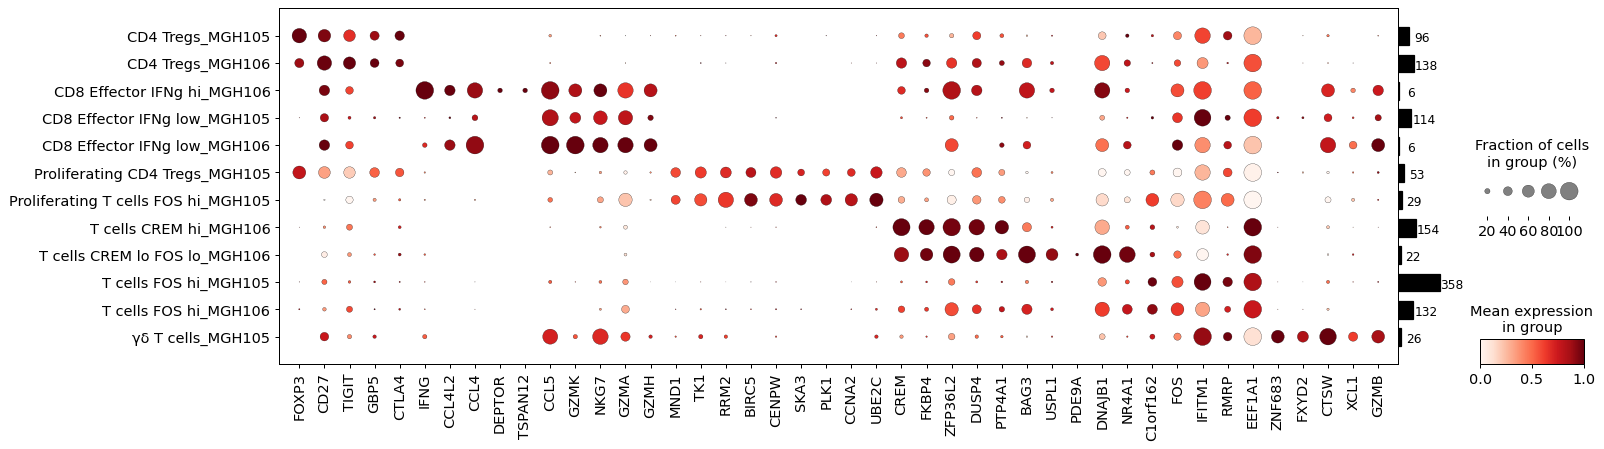

In [111]:
f.savefig('figures/dotplot_markers_by_patient.pdf')

In [92]:
markers = sdf.loc[sdf.groupby('group').spring_score.head(10).index].names.unique()

In [94]:
sc.pl.umap(ad, color=markers, cmap='Reds', size=50, frameon=False, save='-tcr-markers.pdf', ncols=8)

In [95]:
dotplot_spring(ad, 'prediction', mean_only_expressed=True, n_genes=5, standard_scale='var', save='-tcr-markers.pdf')

In [101]:
sc.tl.rank_genes_groups(ad, groupby='prediction', use_raw=False)

In [102]:
sc.tl.dendrogram(ad, 'prediction')

In [103]:
ad

AnnData object with n_obs × n_vars = 1138 × 23975
    obs: '10x_cell_calling', 'sample_name', 'raw', 'empty_drops_FDR', 'neg_log10_empty_drops_FDR', 'n_umis', 'n_genes', 'log10_n_umis', 'log10_n_genes', 'barcode_rank', 'mt_frac', 'n_counts', 'scrublet', 'scrublet_score', 'predicted_sex', 'S_score', 'G2M_score', 'phase', 'leiden', 'IR_VJ_1_locus', 'IR_VJ_2_locus', 'IR_VDJ_1_locus', 'IR_VDJ_2_locus', 'IR_VJ_1_cdr3', 'IR_VJ_2_cdr3', 'IR_VDJ_1_cdr3', 'IR_VDJ_2_cdr3', 'IR_VJ_1_cdr3_nt', 'IR_VJ_2_cdr3_nt', 'IR_VDJ_1_cdr3_nt', 'IR_VDJ_2_cdr3_nt', 'IR_VJ_1_expr', 'IR_VJ_2_expr', 'IR_VDJ_1_expr', 'IR_VDJ_2_expr', 'IR_VJ_1_expr_raw', 'IR_VJ_2_expr_raw', 'IR_VDJ_1_expr_raw', 'IR_VDJ_2_expr_raw', 'IR_VJ_1_v_gene', 'IR_VJ_2_v_gene', 'IR_VDJ_1_v_gene', 'IR_VDJ_2_v_gene', 'IR_VJ_1_d_gene', 'IR_VJ_2_d_gene', 'IR_VDJ_1_d_gene', 'IR_VDJ_2_d_gene', 'IR_VJ_1_j_gene', 'IR_VJ_2_j_gene', 'IR_VDJ_1_j_gene', 'IR_VDJ_2_j_gene', 'IR_VJ_1_c_gene', 'IR_VJ_2_c_gene', 'IR_VDJ_1_c_gene', 'IR_VDJ_2_c_gene', 'IR_VJ_1_j

In [104]:
#ad = ad[:, ~(ad.var_names.str.startswith('RPL') | ad.var_names.str.startswith('RPS'))].copy()

## TCR

In [11]:
#ir.io.upgrade_schema(ad)

In [28]:
ir.tl.chain_qc(ad)

... storing 'receptor_type' as categorical
... storing 'receptor_subtype' as categorical
... storing 'chain_pairing' as categorical
... storing 'clonal_expansion' as categorical


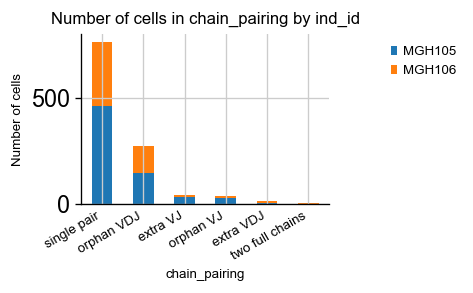

In [29]:
ax = ir.pl.group_abundance(ad, groupby="chain_pairing", target_col='ind_id')

<AxesSubplot:title={'center':'Number of cells in chain_pairing by prediction'}, xlabel='chain_pairing', ylabel='Number of cells'>

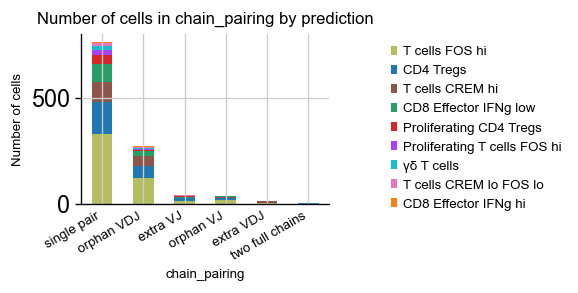

In [30]:
ir.pl.group_abundance(ad, groupby="chain_pairing", target_col="prediction")

<AxesSubplot:title={'center':'Number of cells in receptor_subtype by ind_id'}, xlabel='receptor_subtype', ylabel='Number of cells'>

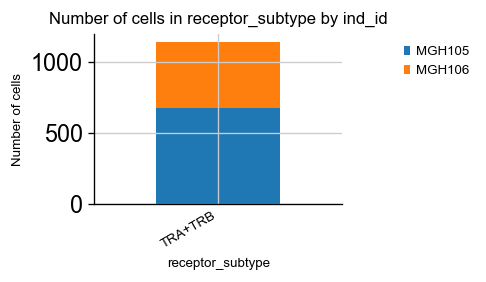

In [31]:
ir.pl.group_abundance(ad, groupby="receptor_subtype", target_col="ind_id")

In [32]:
#ir.pp.ir_dist(ad, sequence='aa')

In [33]:
# using default parameters, `ir_neighbors` will compute nucleotide sequence identity
ir.pp.ir_neighbors(ad, sequence='aa', receptor_arms='VDJ')
ir.tl.define_clonotype_clusters(ad)

100%|██████████| 11163/11163 [00:00<00:00, 176723.76it/s]


In [34]:
ir.tl.clonotype_network(ad, sequence='aa')

... storing 'ct_cluster_aa_identity' as categorical


array([<AxesSubplot:title={'center':'ind_id'}, xlabel='clonotype_network1', ylabel='clonotype_network2'>],
      dtype=object)

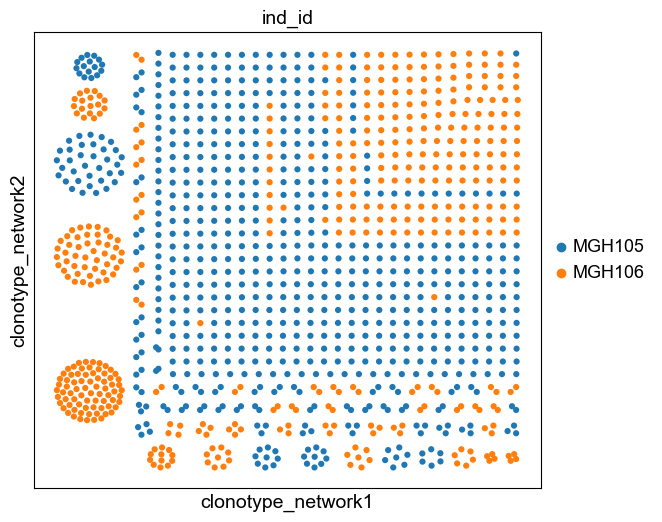

In [35]:
ir.pl.clonotype_network(
    ad,
    color="ind_id",
    legend_fontoutline=3,
    size=80,
    panel_size=(6, 6),
    legend_loc="right margin",
)

In [36]:
ir.pp.ir_neighbors(ad, metric='alignment', sequence='aa', cutoff=5)
ir.tl.define_clonotype_clusters(ad, partitions="connected", sequence="aa", metric="alignment", within_group=None)

100%|██████████| 11802/11802 [00:00<00:00, 102892.73it/s]


... storing 'ct_cluster_aa_alignment' as categorical


array([<AxesSubplot:title={'center':'ind_id'}, xlabel='clonotype_network1', ylabel='clonotype_network2'>],
      dtype=object)

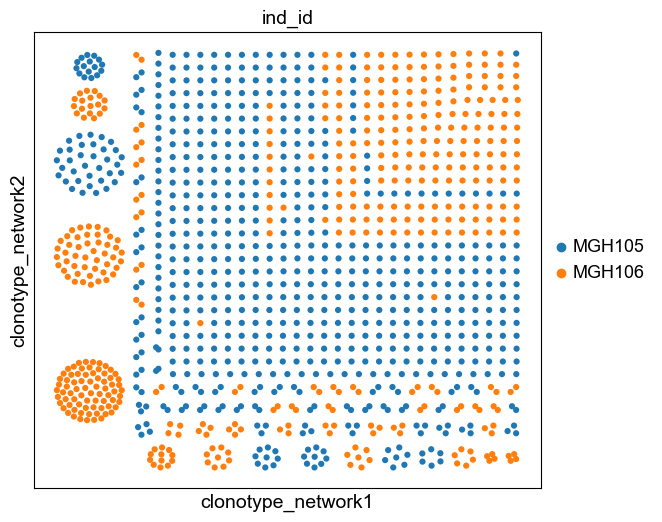

In [37]:
ir.pl.clonotype_network(
    ad,
    color="ind_id",
    legend_fontoutline=3,
    size=80,
    panel_size=(6, 6),
    legend_loc="right margin",
)

In [38]:
ir.pp.ir_neighbors(
    ad,
    metric="alignment",
    sequence="aa",
    cutoff=15,
    receptor_arms="all",
    dual_ir="all",
)
ir.tl.define_clonotype_clusters(
    ad, partitions="connected", sequence="aa", metric="alignment", within_group=None
)

100%|██████████| 13682/13682 [00:00<00:00, 123785.51it/s]


In [39]:
ir.tl.clonotype_network(ad, min_size=3, sequence="aa", metric="alignment")

... storing 'ct_cluster_aa_alignment' as categorical


array([<AxesSubplot:title={'center':'ind_id'}, xlabel='clonotype_network1', ylabel='clonotype_network2'>],
      dtype=object)

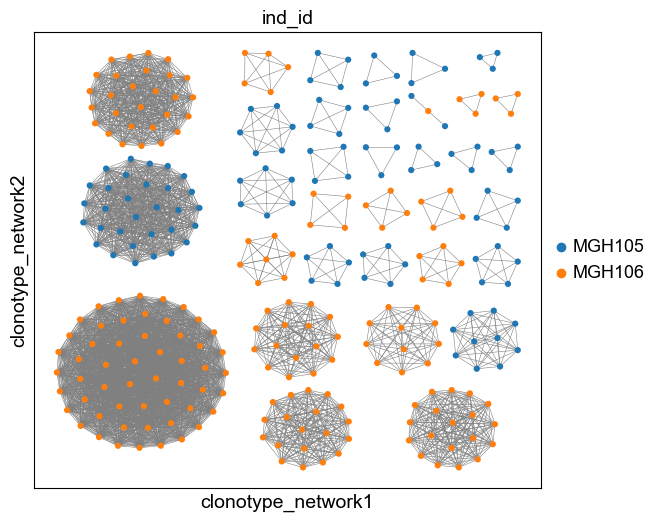

In [40]:
ir.pl.clonotype_network(
    ad,
    color="ind_id",
    legend_fontoutline=3,
    size=80,
    panel_size=(6, 6),
    legend_loc="right margin",
)

In [41]:
ad.obs.ct_cluster_aa_alignment_size

AAACCTGAGACAATAC-1-MGH105     1
AAACCTGCAGGCTCAC-1-MGH105     1
AAACGGGGTGCGGTAA-1-MGH105     2
AAAGCAACATGAAGTA-1-MGH105     1
AAAGCAAGTTAAGGGC-1-MGH105     1
                             ..
TTGTAGGCACGGTTTA-1-MGH106     1
TTTACTGTCAACACTG-1-MGH106     2
TTTGCGCCAAGAGGCT-1-MGH106     1
TTTGGTTCATGACATC-1-MGH106    16
TTTGTCACAGCTGTGC-1-MGH106    19
Name: ct_cluster_aa_alignment_size, Length: 1138, dtype: int64

In [42]:
ir.tl.clonal_expansion(ad, target_col='ct_cluster_aa_identity_size')

In [43]:
sc.set_figure_params(scanpy=False, dpi=100)

<AxesSubplot:>

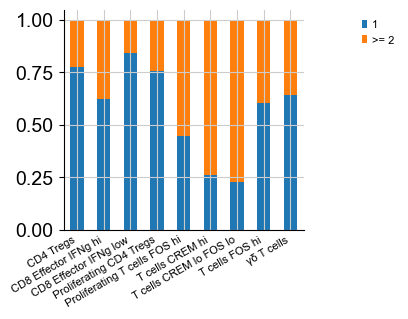

In [44]:
f, ax = plt.subplots()

ir.pl.clonal_expansion(ad, groupby="prediction", target_col='ct_cluster_aa_identity', clip_at=2, ax=ax)

... storing 'clonal_expansion' as categorical


<AxesSubplot:title={'center':'Fraction of prediction in each ct_cluster_aa_identity'}, xlabel='ct_cluster_aa_identity', ylabel='Fraction of cells in ind_id'>

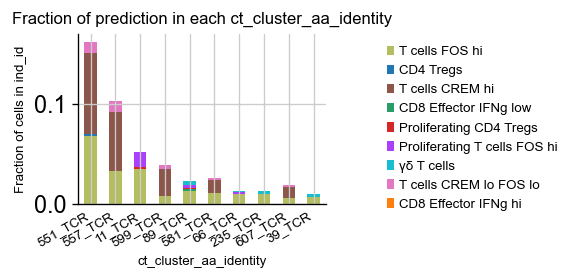

In [45]:
ir.pl.group_abundance(ad, groupby="ct_cluster_aa_identity", target_col="prediction", max_cols=10, normalize="ind_id")

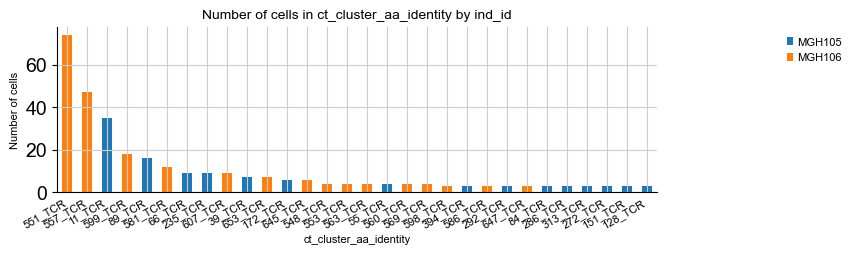

In [46]:
f, ax = plt.subplots(figsize=(10,3))
ir.pl.group_abundance(ad, groupby="ct_cluster_aa_identity", target_col="ind_id", max_cols=30, ax=ax)
f.savefig('figures/clone-size-by-patient.pdf')

<AxesSubplot:title={'center':'Fraction of prediction in each IR_VJ_1_v_gene'}, xlabel='IR_VJ_1_v_gene', ylabel='Fraction of cells in prediction'>

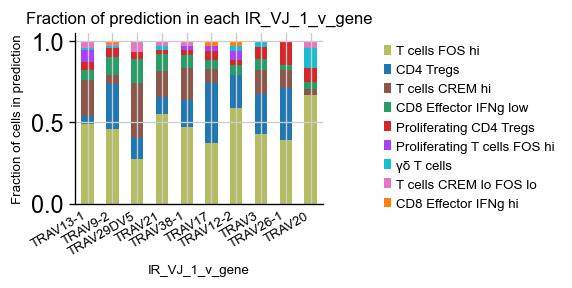

In [47]:
ir.pl.group_abundance(
    ad, groupby="IR_VJ_1_v_gene", target_col="prediction", normalize=True, max_cols=10
)

<AxesSubplot:>

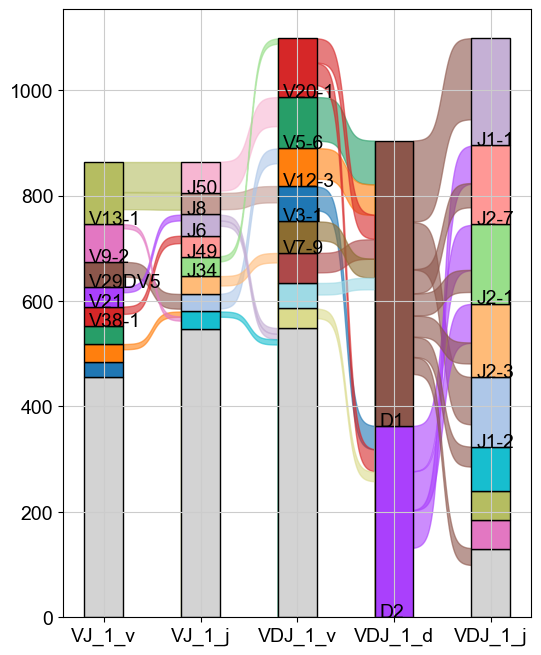

In [48]:
ir.pl.vdj_usage(ad, full_combination=False, max_segments=8, fig_kws={'figsize': (6,8)})

In [49]:
cs = ad.obs.ct_cluster_aa_identity.value_counts()

In [50]:
cool_groups = cs[cs>3].index.tolist()
cool_groups

['551_TCR',
 '557_TCR',
 '11_TCR',
 '599_TCR',
 '89_TCR',
 '581_TCR',
 '66_TCR',
 '235_TCR',
 '607_TCR',
 '39_TCR',
 '653_TCR',
 '172_TCR',
 '645_TCR',
 '548_TCR',
 '553_TCR',
 '563_TCR',
 '55_TCR',
 '560_TCR',
 '569_TCR']

In [51]:
pd.options.display.max_columns = 100

In [ ]:
ad.obs

In [54]:
cols = [
    "IR_VJ_1_cdr3",
    "IR_VJ_1_v_gene",    
    "IR_VJ_1_j_gene",
    "IR_VDJ_1_cdr3",
    'IR_VDJ_1_v_gene',
    "IR_VDJ_1_d_gene",
    "IR_VDJ_1_j_gene",
    "receptor_subtype",
    'ct_cluster_aa_identity',
    'ind_id',
]


tcr_table = ad.obs.loc[ad.obs["ct_cluster_aa_identity"].isin(cool_groups), cols].reset_index(drop=True).astype(str)
clone_size_df = tcr_table.groupby('ct_cluster_aa_identity', as_index=False, observed=True, dropna=False).size().rename(columns={'size': 'clone_size'})
group_size_df = tcr_table.groupby(tcr_table.columns.tolist(), as_index=False, observed=True, dropna=False).size().rename(columns={'size': 'group_size'})
tcr_table = tcr_table.drop_duplicates().sort_values('ct_cluster_aa_identity')
tcr_table = tcr_table.merge(clone_size_df).merge(group_size_df)

tcr_table.sort_values(['clone_size', 'ct_cluster_aa_identity', 'group_size'], ascending=False).to_excel('SuppTable8.xlsx', index=False)

In [293]:
cols = [
    #"IR_VJ_1_cdr3",
    #"IR_VJ_1_v_gene",    
    #"IR_VJ_1_j_gene",
    "IR_VDJ_1_cdr3",
    #'IR_VDJ_1_v_gene',
    #"IR_VDJ_1_d_gene",
    #"IR_VDJ_1_j_gene",
    #"receptor_subtype",
    'ct_cluster_aa_identity',
    'ind_id',
]


#tcr_table = ad.obs.loc[ad.obs["ct_cluster_aa_identity"].isin(cool_groups), cols].reset_index(drop=True).astype(str)
tcr_table = ad.obs.loc[:, cols].reset_index(drop=True).astype(str)
clone_size_df = tcr_table.groupby('ct_cluster_aa_identity', as_index=False, observed=True, dropna=False).size().rename(columns={'size': 'clone_size'})
#group_size_df = tcr_table.groupby(tcr_table.columns.tolist(), as_index=False, observed=True, dropna=False).size().rename(columns={'size': 'group_size'})
tcr_table = tcr_table.drop_duplicates().sort_values('ct_cluster_aa_identity')
tcr_table = tcr_table.merge(clone_size_df) #.merge(group_size_df)

final = tcr_table.sort_values(['clone_size', 'ct_cluster_aa_identity'], ascending=False)
final = final[final.isnull().sum(1) == 0]
final.to_excel('tcr-vdj-table.xlsx', index=False)
final

IR_VDJ_1_cdr3 ct_cluster_aa_identity  ind_id  clone_size
501     CASSLGAWFGGRRTEAFF                551_TCR  MGH106          74
507         CASSLLGADYGYTF                557_TCR  MGH106          47
22         CASSRALAGDYEQYF                 11_TCR  MGH105          35
553         CASSQDRGNEKLFF                599_TCR  MGH106          18
778     CASSGEQTSTFQGTEAFF                 89_TCR  MGH105          16
..                     ...                    ...     ...         ...
8              CASSLGREQFF                107_TCR  MGH105           1
6           CASSYRATSLPLHF                105_TCR  MGH105           1
4             CSATDLGDTQYF                103_TCR  MGH105           1
3    CASSQGGLAGGPYDPTDTQYF                102_TCR  MGH105           1
1         CASSQPTGGIQSSQFF                100_TCR  MGH105           1

[752 rows x 4 columns]

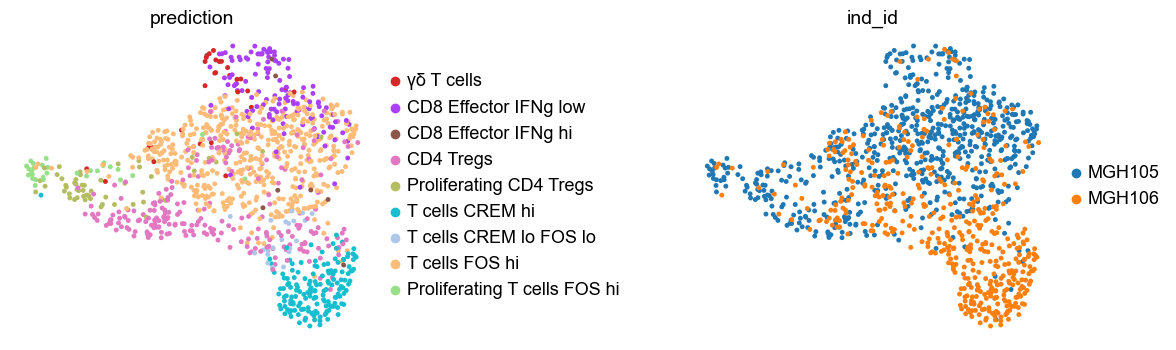

In [295]:
sc.pl.umap(ad, color=['prediction', 'ind_id'], size=50, frameon=False, wspace=0.7)

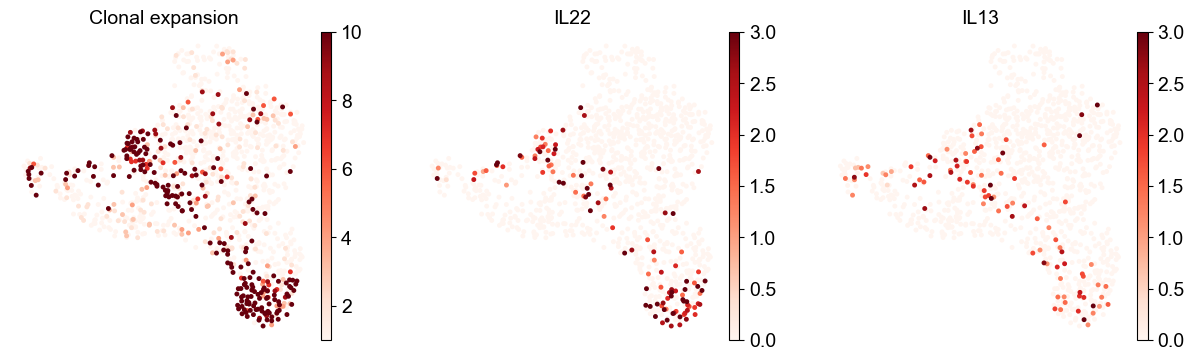

In [296]:
sc.pl.umap(ad, color=['ct_cluster_aa_identity_size', 'IL22', 'IL13'], groups=cool_groups[:4], size=50, frameon=False, cmap='Reds', title=['Clonal expansion', 'IL22', 'IL13'], vmax=[10, 3, 3])

In [297]:
from matplotlib.colors import LinearSegmentedColormap

cmap = LinearSegmentedColormap.from_list('custom', ['#FFD978' , '#FC0000', '#000000'])

In [298]:
%matplotlib inline

In [299]:
ad.obs.ct_cluster_aa_identity_size.max()

74

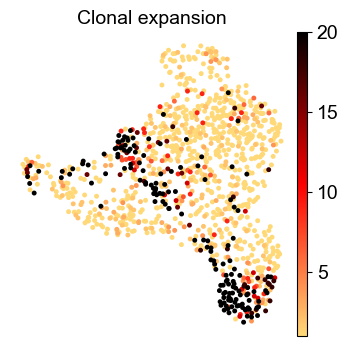

In [300]:
sc.pl.umap(ad, color='ct_cluster_aa_identity_size', size=50, frameon=False, title=['Clonal expansion', 'IL22', 'IL13'], vmax=20, cmap=cmap, save='-clone-customgradient.pdf')

In [82]:
ad.layers['scaled'] = ad.X.copy()
sc.pp.scale(ad, max_value=10, layer='scaled')

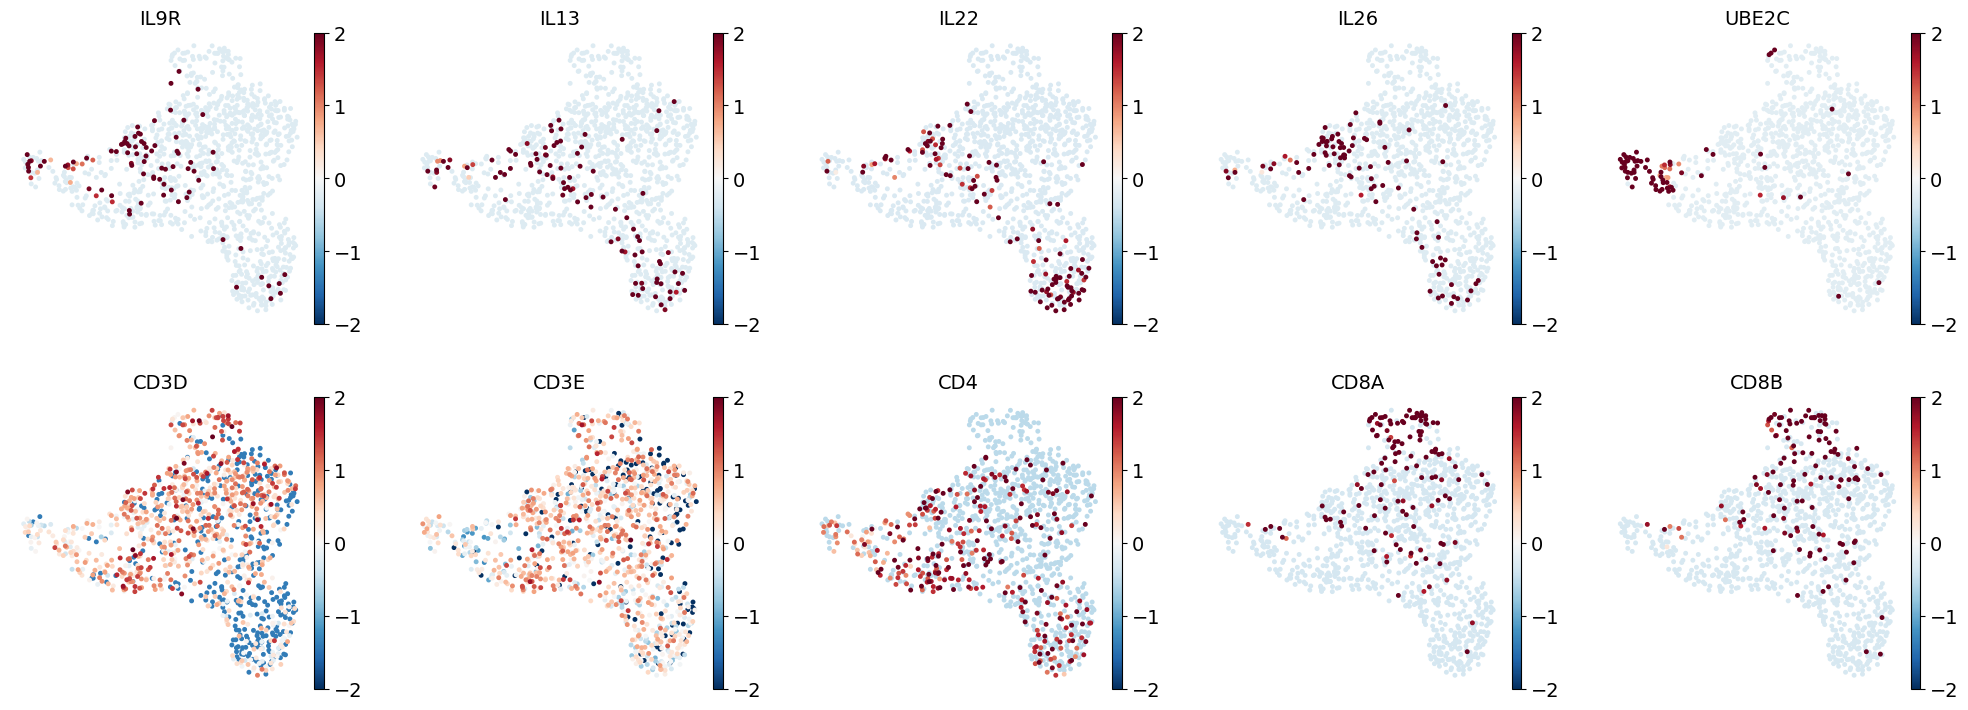

In [88]:
sc.pl.umap(ad, color=['IL9R', 'IL13', 'IL22', 'IL26', 'UBE2C', 'CD3D', 'CD3E', 'CD4', 'CD8A', 'CD8B'], layer='scaled', frameon=False, cmap='RdBu_r', vmin=-2, vmax=2, ncols=5, save='-cytokine-tcell-markers.pdf', size=50)

In [55]:
cutoff = 1
ad.obs['clone_binary'] = [f'>={cutoff+1}' if x else f'{cutoff}' for x in ad.obs['ct_cluster_aa_identity_size']>cutoff]

In [56]:
ad.uns['clone_binary_colors'] = ['lightgray', '#890011']

In [57]:
%matplotlib inline

... storing 'clone_binary' as categorical


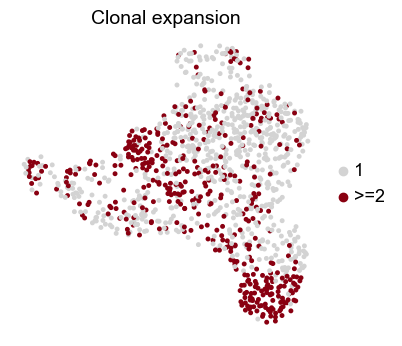

In [58]:
sc.pl.umap(ad, color='clone_binary', size=50, title='Clonal expansion', frameon=False, save='-clone-binary.pdf')

/home/gokcen/.miniconda/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 8.0 x 0.8 in image.
/home/gokcen/.miniconda/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: figures/barplot-clonalexpansion-by-states.pdf
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


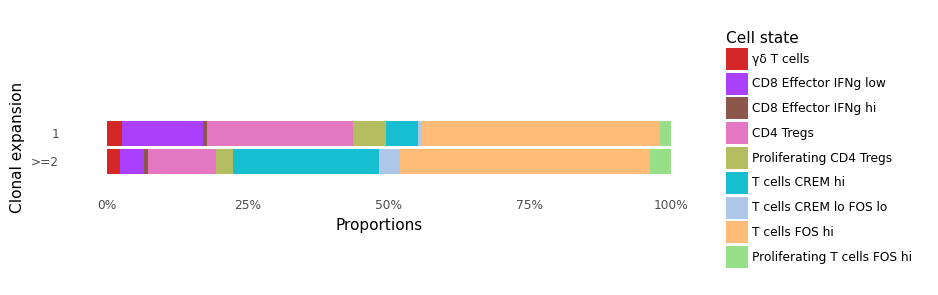

<ggplot: (8752185118705)>

In [46]:
from plotnine import *


g = plot_proportion_barplot(ad, 'clone_binary', 'prediction', show_percent=False, yaxis_label='Clonal expansion', fill_label='Cell state')
ggsave(g, 'figures/barplot-clonalexpansion-by-states.pdf')
g

In [104]:
genes = ['IL13', 'IL22', 'IL26']

for gene in genes:
    ad.obs[f'{gene}+'] = ['Expressed' if x>0 else 'Not expressed' for x in ad.obs_vector(gene)]
    
ad.obs['IL22/IL26'] = [f'IL22{"+" if x else "-"}IL26{"+" if y else "-"}' for x,y in zip(ad.obs_vector('IL22')>0, ad.obs_vector('IL26')>0)]
ad.obs['IL13/IL26'] = [f'IL13{"+" if x else "-"}IL26{"+" if y else "-"}' for x,y in zip(ad.obs_vector('IL13')>0, ad.obs_vector('IL26')>0)]
ad.obs['IL13/IL22'] = [f'IL13{"+" if x else "-"}IL22{"+" if y else "-"}' for x,y in zip(ad.obs_vector('IL13')>0, ad.obs_vector('IL22')>0)]

ad._sanitize()

ad.uns['IL22/IL26_colors'] = ['purple', '#DA3C3D', '#3584BB', 'darkgrey']
ad.uns['IL13/IL26_colors'] = ['purple', '#DA3C3D', '#3584BB', 'darkgrey']
ad.uns['IL13/IL22_colors'] = ['purple', '#DA3C3D', '#3584BB', 'darkgrey']

... storing 'IL13+' as categorical
... storing 'IL22+' as categorical
... storing 'IL26+' as categorical
... storing 'IL22/IL26' as categorical
... storing 'IL13/IL26' as categorical
... storing 'IL13/IL22' as categorical


/home/gokcen/.miniconda/lib/python3.8/site-packages/anndata/compat/__init__.py:211: FutureWarning: During AnnData slicing, found matrix at .uns['ir_neighbors_aa_identity']['connectivities'] that happens to be dimensioned at n_obs×n_obs (1138×1138).

These matrices should now be stored in the .obsp attribute.
This slicing behavior will be removed in anndata 0.8.
/home/gokcen/.miniconda/lib/python3.8/site-packages/anndata/compat/__init__.py:211: FutureWarning: During AnnData slicing, found matrix at .uns['ir_neighbors_aa_identity']['distances'] that happens to be dimensioned at n_obs×n_obs (1138×1138).

These matrices should now be stored in the .obsp attribute.
This slicing behavior will be removed in anndata 0.8.
/home/gokcen/.miniconda/lib/python3.8/site-packages/anndata/compat/__init__.py:211: FutureWarning: During AnnData slicing, found matrix at .uns['ir_neighbors_aa_alignment']['connectivities'] that happens to be dimensioned at n_obs×n_obs (1138×1138).

These matrices should now 

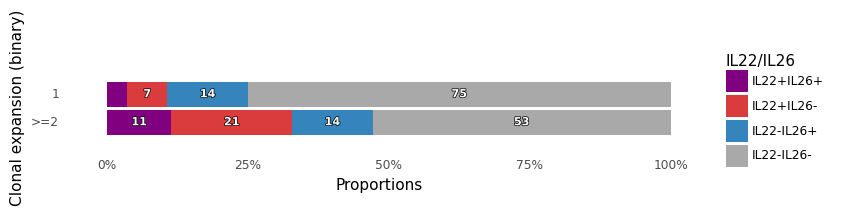

<ggplot: (8768563903594)>

In [123]:
g = plot_proportion_barplot(ad[(ad.obs_vector('IL13')>0)], 'clone_binary', 'IL22/IL26', yaxis_label='Clonal expansion (binary)')
ggsave(g, 'figures/barplot-clonalexpansion-by-il13-22-26.pdf')
g

In [30]:
sc.set_figure_params(scanpy=False, dpi=100)

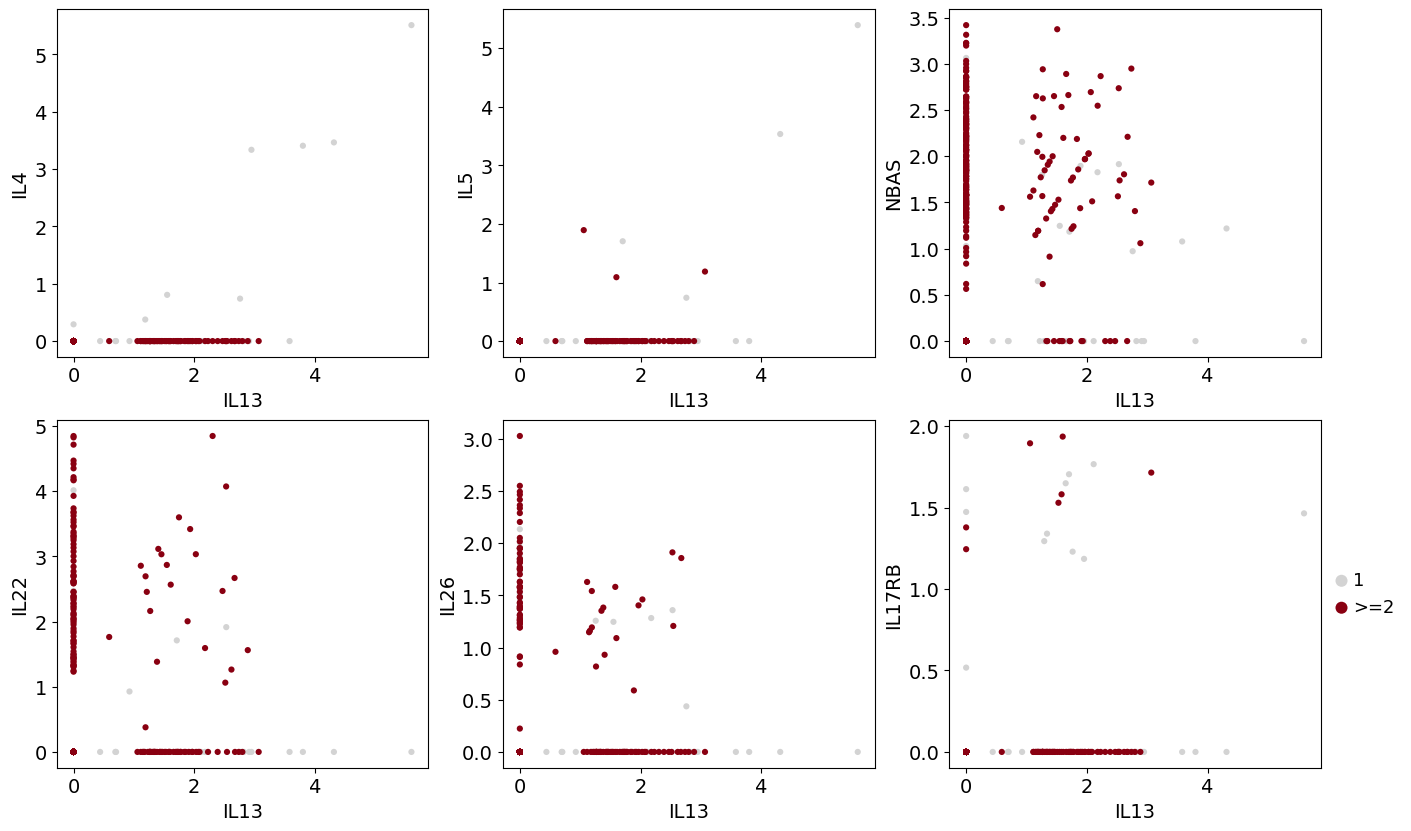

<Figure size 400x400 with 0 Axes>

In [126]:
f, axs = plt.subplots(2, 3, constrained_layout=True, figsize=(14,8.2))
axs = axs.flatten()
[x.grid(False) for x in axs]

sc.pl.scatter(ad, 'IL13', 'IL4', color='clone_binary', legend_loc='none', ax=axs[0], show=False, title='', size=80)
sc.pl.scatter(ad, 'IL13', 'IL5', color='clone_binary', legend_loc='none', ax=axs[1], show=False, title='', size=80)
sc.pl.scatter(ad, 'IL13', 'NBAS', color='clone_binary', legend_loc='none', ax=axs[2], show=False, title='', size=80)
sc.pl.scatter(ad, 'IL13', 'IL22', color='clone_binary', legend_loc='none', ax=axs[3], show=False, title='', size=80)
sc.pl.scatter(ad, 'IL13', 'IL26', color='clone_binary', legend_loc='none', ax=axs[4], show=False, title='', size=80)
sc.pl.scatter(ad, 'IL13', 'IL17RB', color='clone_binary', ax=axs[5], title='', size=80)

plt.subplots_adjust(hspace=0.9)

f.savefig('figures/th2-22-coexp-by-clonalexp.pdf')

In [205]:
ad.obs['CD4/CD8'] = [f'CD4{"+" if cd4 else "-"}CD8{"+" if cd8 else "-"}' for cd4, cd8 in zip(ad.obs_vector('CD4')>0, ad.obs_vector('CD8A')>0)]

/home/gokcen/.miniconda/lib/python3.8/site-packages/anndata/compat/__init__.py:211: FutureWarning: During AnnData slicing, found matrix at .uns['ir_neighbors_aa_identity']['connectivities'] that happens to be dimensioned at n_obs×n_obs (1138×1138).

These matrices should now be stored in the .obsp attribute.
This slicing behavior will be removed in anndata 0.8.
/home/gokcen/.miniconda/lib/python3.8/site-packages/anndata/compat/__init__.py:211: FutureWarning: During AnnData slicing, found matrix at .uns['ir_neighbors_aa_identity']['distances'] that happens to be dimensioned at n_obs×n_obs (1138×1138).

These matrices should now be stored in the .obsp attribute.
This slicing behavior will be removed in anndata 0.8.
/home/gokcen/.miniconda/lib/python3.8/site-packages/anndata/compat/__init__.py:211: FutureWarning: During AnnData slicing, found matrix at .uns['ir_neighbors_aa_alignment']['connectivities'] that happens to be dimensioned at n_obs×n_obs (1138×1138).

These matrices should now 

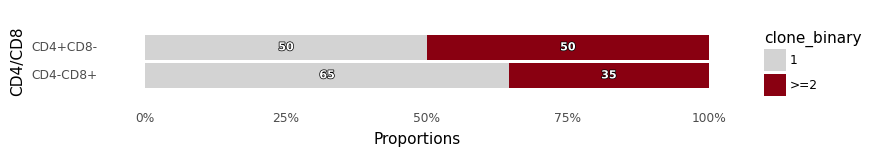

<ggplot: (8764415262531)>

In [215]:
g = plot_proportion_barplot(ad[ad.obs['CD4/CD8'].isin(['CD4+CD8-', 'CD4-CD8+'])], 'CD4/CD8', 'clone_binary')

ggsave(g, 'figures/tcr-cd4-8-proportion1.pdf')
g

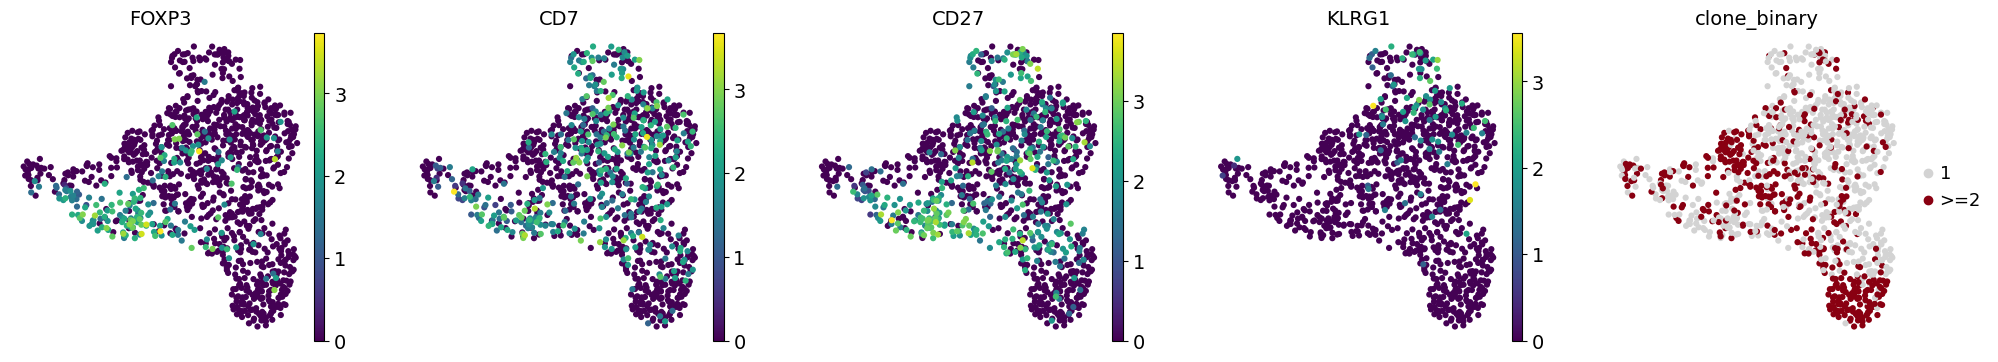

In [85]:
sc.pl.umap(ad, color=['FOXP3', 'CD7', 'CD27', 'KLRG1', 'clone_binary'], size=80, frameon=False, ncols=5)

/home/gokcen/.miniconda/lib/python3.8/site-packages/anndata/compat/__init__.py:211: FutureWarning: During AnnData slicing, found matrix at .uns['ir_neighbors_aa_identity']['connectivities'] that happens to be dimensioned at n_obs×n_obs (1138×1138).

These matrices should now be stored in the .obsp attribute.
This slicing behavior will be removed in anndata 0.8.
/home/gokcen/.miniconda/lib/python3.8/site-packages/anndata/compat/__init__.py:211: FutureWarning: During AnnData slicing, found matrix at .uns['ir_neighbors_aa_identity']['distances'] that happens to be dimensioned at n_obs×n_obs (1138×1138).

These matrices should now be stored in the .obsp attribute.
This slicing behavior will be removed in anndata 0.8.
/home/gokcen/.miniconda/lib/python3.8/site-packages/anndata/compat/__init__.py:211: FutureWarning: During AnnData slicing, found matrix at .uns['ir_neighbors_aa_alignment']['connectivities'] that happens to be dimensioned at n_obs×n_obs (1138×1138).

These matrices should now 

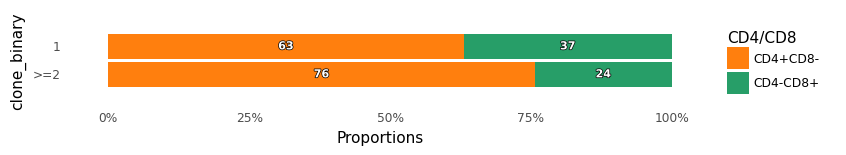

<ggplot: (8764415177722)>

In [217]:
g = plot_proportion_barplot(ad[ad.obs['CD4/CD8'].isin(['CD4+CD8-', 'CD4-CD8+'])], 'clone_binary', 'CD4/CD8')

ggsave(g, 'figures/tcr-cd4-8-proportion2.pdf')
g

In [211]:
ad._inplace_subset_var(~((ad.var_names.str.startswith('RPL') | ad.var_names.str.startswith('RPS') | ad.var_names.str.startswith('MTRNR'))))

In [59]:
sc.tl.rank_genes_groups(ad, groupby='clone_binary', use_raw=False)

In [60]:
dedf = sc.get.rank_genes_groups_df(ad, group=None)
dedf

group     names    scores  logfoldchanges         pvals     pvals_adj
0         1  MTRNR2L8  9.236351        1.840240  1.800930e-19  3.084093e-16
1         1       CD7  7.758587        1.484809  1.975970e-14  1.597381e-11
2         1    GIMAP4  7.492035        1.928548  1.363788e-13  8.024616e-11
3         1     RPS24  7.317093        0.397795  5.580492e-13  2.846644e-10
4         1    GIMAP7  7.304253        1.479756  5.279015e-13  2.751400e-10
...     ...       ...       ...             ...           ...           ...
47945   >=2    GIMAP7 -7.304253       -1.479756  5.279015e-13  2.751400e-10
47946   >=2     RPS24 -7.317093       -0.397795  5.580492e-13  2.846644e-10
47947   >=2    GIMAP4 -7.492035       -1.928548  1.363788e-13  8.024616e-11
47948   >=2       CD7 -7.758587       -1.484809  1.975970e-14  1.597381e-11
47949   >=2  MTRNR2L8 -9.236351       -1.840240  1.800930e-19  3.084093e-16

[47950 rows x 6 columns]

In [64]:
x = sc.get.rank_genes_groups_df(ad, group=None, pval_cutoff=0.1)
x.group = x.group.str.replace('1', 'Non-expanded (n=1)')
x.group = x.group.str.replace('>=2', 'Expanded (n>=2)')

x.to_excel('SuppTable9.xlsx', index=False)

## IL13 genes from the topic modeling

In [229]:
import pickle
tm = pickle.load(open('../Lymphocytes-with-topics-10k.pkl', 'rb'))

In [230]:
tops = tm.topics(l=0, n=None)

In [232]:
il_topic = [k for k,v in tops.items() if 'IL13' in [i[0] for i in v]][0]

In [233]:
il13_genes = [x[0] for x in tops[il_topic]]

## t-test volcano

In [235]:
highlights = ['IL22', 'IL13', 'IL26', 'IL9R', 'CD7', 'GZMB', 'GZMK', 'KLRG1', 'CD27', 'FOXP3', 'HLA-DRA', 'HLA-DRB1', 'IL4', 'IL5', 'IL17RB', 'PPARG', 'PTHLH', 'HPGDS', 'IL31', 'NBAS', 'SELL', 'LAIR1', 'LGALS1', 'PTGDR2', 'CHDH', 'HPGDS', 'LGALS3'] + il13_genes

In [236]:
#highlights = ['CD4', 'CD8A', 'IL26', 'CD8B']

df = sc.get.rank_genes_groups_df(ad, '>=2') #[2:]
df['neglogpval'] = -np.log10(df.pvals_adj)
df['significant'] = (df.pvals_adj<0.1) & (df.logfoldchanges.abs()>0.5)
df['highlight'] = df.names.isin(highlights)

df

names     scores  logfoldchanges         pvals     pvals_adj  \
0        NBAS  14.555853        3.155257  4.046529e-41  9.657446e-37   
1        LMO4  13.085585        2.615263  7.909073e-35  9.437897e-31   
2      LGALS3  12.441240        1.692381  6.625542e-33  5.058029e-29   
3      LGALS1  12.320894        1.465614  8.477380e-33  5.058029e-29   
4       NR3C1  10.362648        1.993210  1.831915e-23  7.286748e-20   
...       ...        ...             ...           ...           ...   
23861    CD27  -7.078620       -1.335605  2.619624e-12  1.250399e-09   
23862     LTB  -7.204808       -1.084240  1.126582e-12  5.601458e-10   
23863  GIMAP7  -7.304253       -1.479756  5.279015e-13  2.799755e-10   
23864  GIMAP4  -7.492035       -1.928548  1.363788e-13  8.182965e-11   
23865     CD7  -7.758587       -1.484809  1.975970e-14  1.644950e-11   

       neglogpval  significant  highlight  
0       36.015138         True       True  
1       30.025125         True      False  
2       28.296019         True       True  
3       28.296019         True       True  
4       19.137466         True      False  
...           ...          ...        ...  
23861    8.902951         True       True  
23862    9.251699         True      False  
23863    9.552880         True      False  
23864   10.087089         True      False  
23865   10.783847         True       True  

[23866 rows x 8 columns]

/home/gokcen/.miniconda/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 8 x 6 in image.
/home/gokcen/.miniconda/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: figures/tcr-1-vs2-ttest-volcano.pdf
/home/gokcen/.miniconda/lib/python3.8/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 2907 rows containing missing values.
/home/gokcen/.miniconda/lib/python3.8/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 10 rows containing missing values.
/home/gokcen/.miniconda/lib/python3.8/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 2907 rows containing missing values.
/home/gokcen/.miniconda/lib/python3.8/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 10 rows containing missing values.


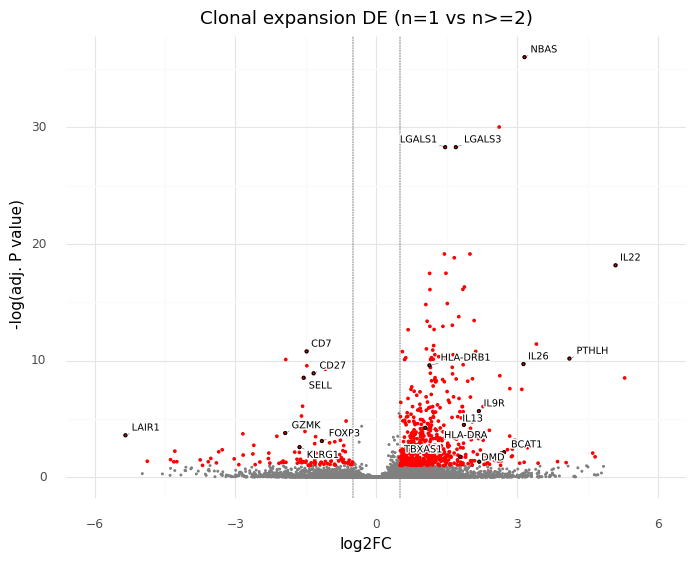

<ggplot: (8772460906174)>

In [237]:
import matplotlib.patheffects as path_effects
import plotnine as p9

f = (
    p9.ggplot(p9.aes(x='logfoldchanges', y='neglogpval'), data=df) + 

    p9.geom_vline(xintercept=0.5, size=0.2, linetype='dashed') +
    p9.geom_vline(xintercept=-0.5, size=0.2, linetype='dashed') +    
    
    p9.geom_point(size=0.2, color='gray', data=df[~df.significant]) + 
    p9.geom_point(size=0.5, color='red', data=df[df.significant]) +
    p9.geom_point(size=0.7, fill='red', color='black', data=df[df.highlight & (df.significant)]) +         
    p9.geom_text(p9.aes(label='names'), data=df[df.highlight & (df.significant)], size=7,
             adjust_text = {
                 'x': df[df.highlight].logfoldchanges.values,
                 'y': df[df.highlight].neglogpval.values,
                 'expand_points': (1.5, 1.5), 
                 'arrowprops': {'arrowstyle': '-', 'color': 'gray', 'lw':0.5} 
             }, path_effects=[
                 path_effects.Stroke(linewidth=2, foreground='white'),
                 path_effects.Normal()
             ]) +

    p9.theme_minimal() + 
    p9.labs(x='log2FC', y='-log(adj. P value)', title='Clonal expansion DE (n=1 vs n>=2)') + 
    p9.theme(figure_size=(8,6)) +
    p9.lims(x=(-6,6))
)

p9.ggsave(f, 'figures/tcr-1-vs2-ttest-volcano.pdf')
f

In [238]:
sdf = run_spring(ad, 'clone_binary')

/home/gokcen/.miniconda/lib/python3.8/site-packages/scrublet/helper_functions.py:175: RuntimeWarning: divide by zero encountered in true_divide


  0%|          | 0/2 [00:00<?, ?it/s]

In [193]:
sdf[sdf.group == '>=2'].head(60)

names  spring_score group
23975      NBAS      0.559281   >=2
23976      LMO4      0.500120   >=2
23977      IL22      0.443830   >=2
23978    LGALS3      0.440193   >=2
23979    LGALS1      0.405444   >=2
23980     NR3C1      0.401474   >=2
23981     COTL1      0.371363   >=2
23982     DUSP4      0.368294   >=2
23983      JAML      0.368044   >=2
23984     H2AFZ      0.359850   >=2
23985    HSPA1A      0.356892   >=2
23986      ETS2      0.350421   >=2
23987     SNHG7      0.348443   >=2
23988      SRGN      0.342441   >=2
23989       CLU      0.341944   >=2
23990     PTHLH      0.336343   >=2
23991   ZFP36L2      0.335645   >=2
23992   ALOX5AP      0.329900   >=2
23993    CDKN1A      0.328652   >=2
23994      IL26      0.321087   >=2
23995     PDE4D      0.319084   >=2
23996     NTRK2      0.316834   >=2
23997     GLUD1      0.314294   >=2
23998       TXN      0.311642   >=2
23999     PCBP1      0.309111   >=2
24000      BATF      0.305595   >=2
24001     ANXA1      0.303503   >=2
24002      CREM      0.302875   >=2
24003   TRBV5-6      0.297409   >=2
24004      CD63      0.297304   >=2
24005      GLUL      0.295106   >=2
24006      RBPJ      0.293819   >=2
24007      CAPG      0.292070   >=2
24008      PRNP      0.288427   >=2
24009      YBX1      0.288356   >=2
24010     TRAT1      0.287019   >=2
24011      RGCC      0.286404   >=2
24012  TRBV12-3      0.284529   >=2
24013      AHI1      0.284342   >=2
24014       VIM      0.284126   >=2
24015      ATF4      0.283730   >=2
24016      SELK      0.282994   >=2
24017     ANXA5      0.282358   >=2
24018    PTP4A1      0.282029   >=2
24019    TGFBR3      0.280560   >=2
24020      CSF2      0.278281   >=2
24021   ANKRD28      0.275408   >=2
24022      CYBA      0.272517   >=2
24023       AHR      0.270134   >=2
24024    METTL9      0.269692   >=2
24025     GAPDH      0.269625   >=2
24026  HLA-DRB1      0.268988   >=2
24027     FABP5      0.268120   >=2
24028     HSPA5      0.267424   >=2
24029      CD96      0.264193   >=2
24030    CD40LG      0.262584   >=2
24031    S100A6      0.262211   >=2
24032   TNFSF10      0.261472   >=2
24033      AREG      0.260103   >=2
24034     PLIN2      0.258106   >=2

In [ ]:
pd.crosstab(ad.obs.ct_cluster_aa_identity, ad.obs.prediction).loc[cool_groups]

In [128]:
ad.obs.ct_cluster_aa_identity_size.value_counts()

1     698
2     122
74     74
47     47
3      39
35     35
9      27
4      24
18     18
16     16
7      14
6      12
12     12
Name: ct_cluster_aa_identity_size, dtype: int64

In [60]:
ad.obs['Clone size'] = ad.obs['ct_cluster_aa_identity_size']

In [112]:
sc.pl.umap(ad, color=['Clone size', 'IL9R', 'IL13', 'IL22', 'IL26', 'UBE2C', 'CD3E', 'CD4', 'CD8A', 'ind_id', 'prediction'], cmap='Reds', size=50, frameon=False, vmax=[20, None], save='-tcr-th-tc-2-17.pdf')

ERROR: The parameter vmax is not valid. If setting multiple vmax values,check that the length of the vmax list is equal to the number of plots. 
ERROR: The parameter vmax is not valid. If setting multiple vmax values,check that the length of the vmax list is equal to the number of plots. 
ERROR: The parameter vmax is not valid. If setting multiple vmax values,check that the length of the vmax list is equal to the number of plots. 
ERROR: The parameter vmax is not valid. If setting multiple vmax values,check that the length of the vmax list is equal to the number of plots. 
ERROR: The parameter vmax is not valid. If setting multiple vmax values,check that the length of the vmax list is equal to the number of plots. 
ERROR: The parameter vmax is not valid. If setting multiple vmax values,check that the length of the vmax list is equal to the number of plots. 
ERROR: The parameter vmax is not valid. If setting multiple vmax values,check that the length of the vmax list is equal to the num

In [132]:
ad.write('tcr-integrated.h5ad')

## Clonality classifier

In [347]:
lym.layers['counts'].data

array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)

In [348]:
ad.layers['counts'].data

array([1., 2., 1., ..., 1., 1., 1.], dtype=float32)

In [379]:
ad.obs.clone_binary.value_counts()

1      698
>=2    440
Name: clone_binary, dtype: int64

In [349]:
lym.obs['clone_binary'] = np.nan
model_data = sc.concat([lym, ad], join='inner')
model_data

AnnData object with n_obs × n_vars = 26270 × 23746
    obs: '10x_cell_calling', 'G2M_score', 'S_score', 'barcode_rank', 'empty_drops_FDR', 'ind_id', 'leiden', 'log10_n_genes', 'log10_n_umis', 'mt_frac', 'n_counts', 'n_genes', 'n_umis', 'neg_log10_empty_drops_FDR', 'phase', 'predicted_sex', 'raw', 'sample_name', 'scrublet', 'scrublet_score', 'Cell type granular', 'clone_binary'
    obsm: 'X_harmony', 'X_pca', 'X_umap'
    layers: 'counts'

In [350]:
from pyannotables import tables

t = tables()
t = t['homo_sapiens-GRCh38-ensembl84'][['Chromosome', 'gene_name', 'gene_biotype']].drop_duplicates('gene_name').set_index('gene_name')
t.index.name = None
t.head()

Chromosome    gene_biotype
TSPAN6            X  protein_coding
TNMD              X  protein_coding
DPM1             20  protein_coding
SCYL3             1  protein_coding
C1orf112          1  protein_coding

In [351]:
np.all(model_data.var.join(t, how='left').index == model_data.var_names)

True

In [352]:
model_data.var = model_data.var.join(t, how='left')
model_data

AnnData object with n_obs × n_vars = 26270 × 23746
    obs: '10x_cell_calling', 'G2M_score', 'S_score', 'barcode_rank', 'empty_drops_FDR', 'ind_id', 'leiden', 'log10_n_genes', 'log10_n_umis', 'mt_frac', 'n_counts', 'n_genes', 'n_umis', 'neg_log10_empty_drops_FDR', 'phase', 'predicted_sex', 'raw', 'sample_name', 'scrublet', 'scrublet_score', 'Cell type granular', 'clone_binary'
    var: 'Chromosome', 'gene_biotype'
    obsm: 'X_harmony', 'X_pca', 'X_umap'
    layers: 'counts'

In [353]:
#model_data._inplace_subset_var(((model_data.var.gene_biotype == 'protein_coding') | model_data.var.gene_biotype.str.startswith('TR_')) & (model_data.var.Chromosome.isin([str(x) for x in range(1, 23)] + ['X', 'Y'])))
model_data._inplace_subset_var(((model_data.var.gene_biotype == 'protein_coding')) & (model_data.var.Chromosome.isin([str(x) for x in range(1, 23)] + ['X', 'Y'])))
model_data

AnnData object with n_obs × n_vars = 26270 × 17067
    obs: '10x_cell_calling', 'G2M_score', 'S_score', 'barcode_rank', 'empty_drops_FDR', 'ind_id', 'leiden', 'log10_n_genes', 'log10_n_umis', 'mt_frac', 'n_counts', 'n_genes', 'n_umis', 'neg_log10_empty_drops_FDR', 'phase', 'predicted_sex', 'raw', 'sample_name', 'scrublet', 'scrublet_score', 'Cell type granular', 'clone_binary'
    var: 'Chromosome', 'gene_biotype'
    obsm: 'X_harmony', 'X_pca', 'X_umap'
    layers: 'counts'

In [354]:
model_data.X = model_data.layers['counts'].copy()
sc.pp.normalize_total(model_data, target_sum=10000)
sc.pp.log1p(model_data)

In [355]:
model_data.layers['scaled'] = model_data.X.copy()
sc.pp.scale(model_data, max_value=10, layer='scaled')

In [356]:
from sklearn.linear_model import LogisticRegressionCV

In [357]:
model = LogisticRegressionCV(Cs=100, class_weight='balanced', scoring='balanced_accuracy', n_jobs=32, verbose=5, cv=10)

In [358]:
temp_ad = model_data[~model_data.obs.clone_binary.isnull()].copy()
temp_ad._sanitize()

... storing 'ind_id' as categorical
... storing 'leiden' as categorical
... storing 'sample_name' as categorical
... storing 'scrublet' as categorical
... storing 'clone_binary' as categorical
... storing 'gene_biotype' as categorical


In [359]:
temp_ad.obs.clone_binary

AAACCTGAGACAATAC-1-MGH105      1
AAACCTGCAGGCTCAC-1-MGH105      1
AAACGGGGTGCGGTAA-1-MGH105    >=2
AAAGCAACATGAAGTA-1-MGH105      1
AAAGCAAGTTAAGGGC-1-MGH105      1
                            ... 
TTGTAGGCACGGTTTA-1-MGH106      1
TTTACTGTCAACACTG-1-MGH106    >=2
TTTGCGCCAAGAGGCT-1-MGH106      1
TTTGGTTCATGACATC-1-MGH106    >=2
TTTGTCACAGCTGTGC-1-MGH106    >=2
Name: clone_binary, Length: 1138, dtype: category
Categories (2, object): ['1', '>=2']

In [360]:
%%time

model.fit(temp_ad.layers['scaled'], temp_ad.obs.clone_binary)

[Parallel(n_jobs=32)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done   4 out of  10 | elapsed:  3.0min remaining:  4.5min
[Parallel(n_jobs=32)]: Done   7 out of  10 | elapsed:  3.1min remaining:  1.3min
[Parallel(n_jobs=32)]: Done  10 out of  10 | elapsed:  3.3min remaining:    0.0s
[Parallel(n_jobs=32)]: Done  10 out of  10 | elapsed:  3.3min finished


CPU times: user 1.94 s, sys: 6.76 s, total: 8.7 s
Wall time: 3min 19s


LogisticRegressionCV(Cs=100, class_weight='balanced', cv=10, n_jobs=32,
                     scoring='balanced_accuracy', verbose=5)

In [361]:
model.C_

array([0.00236449])

In [362]:
model.Cs_

array([1.00000000e-04, 1.20450354e-04, 1.45082878e-04, 1.74752840e-04,
       2.10490414e-04, 2.53536449e-04, 3.05385551e-04, 3.67837977e-04,
       4.43062146e-04, 5.33669923e-04, 6.42807312e-04, 7.74263683e-04,
       9.32603347e-04, 1.12332403e-03, 1.35304777e-03, 1.62975083e-03,
       1.96304065e-03, 2.36448941e-03, 2.84803587e-03, 3.43046929e-03,
       4.13201240e-03, 4.97702356e-03, 5.99484250e-03, 7.22080902e-03,
       8.69749003e-03, 1.04761575e-02, 1.26185688e-02, 1.51991108e-02,
       1.83073828e-02, 2.20513074e-02, 2.65608778e-02, 3.19926714e-02,
       3.85352859e-02, 4.64158883e-02, 5.59081018e-02, 6.73415066e-02,
       8.11130831e-02, 9.77009957e-02, 1.17681195e-01, 1.41747416e-01,
       1.70735265e-01, 2.05651231e-01, 2.47707636e-01, 2.98364724e-01,
       3.59381366e-01, 4.32876128e-01, 5.21400829e-01, 6.28029144e-01,
       7.56463328e-01, 9.11162756e-01, 1.09749877e+00, 1.32194115e+00,
       1.59228279e+00, 1.91791026e+00, 2.31012970e+00, 2.78255940e+00,
      

In [363]:
model.scores_['>=2'].max(1)

array([0.72857143, 0.68181818, 0.65616883, 0.6461039 , 0.84512987,
       0.825     , 0.91461039, 0.76883117, 0.79001976, 0.76103426])

In [364]:
model.scores_['>=2'].max(1).mean()

0.7617287784679089

In [365]:
pd.DataFrame(dict(score=model.coef_.flatten(), gene=model_data.var_names)).sort_values('score', ascending=False).head(30).reset_index(drop=True)

score      gene
0   0.052772      NBAS
1   0.051014     PTHLH
2   0.046925      IL22
3   0.038222      IL9R
4   0.034652    LGALS3
5   0.033791    LGALS1
6   0.030455      LMO4
7   0.029222     NTRK2
8   0.027735     GLUD1
9   0.027244      POGK
10  0.027014   ARHGEF3
11  0.026726     RWDD3
12  0.026294    CC2D1A
13  0.026064       CLU
14  0.026033      CAPG
15  0.025628      IL26
16  0.025327      CD63
17  0.025163    TRDMT1
18  0.024673     ITGAE
19  0.024479      NME2
20  0.023943     FARSA
21  0.023630     NR3C1
22  0.023507      JAML
23  0.023254    PRKAB1
24  0.022991  C16orf62
25  0.022935       DR1
26  0.022767     TRAT1
27  0.022577      BATF
28  0.022515      ETS2
29  0.022433      CSF2

In [366]:
signature = temp_ad.var_names[model.coef_.flatten().argsort()[::-1][:30]].tolist()
signature

['NBAS',
 'PTHLH',
 'IL22',
 'IL9R',
 'LGALS3',
 'LGALS1',
 'LMO4',
 'NTRK2',
 'GLUD1',
 'POGK',
 'ARHGEF3',
 'RWDD3',
 'CC2D1A',
 'CLU',
 'CAPG',
 'IL26',
 'CD63',
 'TRDMT1',
 'ITGAE',
 'NME2',
 'FARSA',
 'NR3C1',
 'JAML',
 'PRKAB1',
 'C16orf62',
 'DR1',
 'TRAT1',
 'BATF',
 'ETS2',
 'CSF2']

In [367]:
lym.obs['predicted_clonality'] = model.predict(model_data[lym.obs.index].layers['scaled'])
model_data.obs['predicted_clonality'] = model.predict(model_data.layers['scaled'])

... storing 'predicted_clonality' as categorical


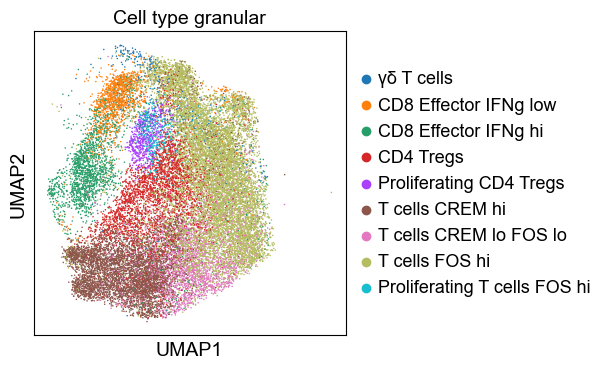

In [368]:
sc.pl.umap(lym, color='Cell type granular')

In [ ]:
sc.pl.umap(model_data[lym.obs_names], color=['predicted_clonality'] + signature, ncols=10, frameon=False, cmap='RdBu_r', layer='scaled', vmin=-2, vmax=2, size=10)

In [370]:
lym

AnnData object with n_obs × n_vars = 25132 × 29991
    obs: '10x_cell_calling', 'G2M_score', 'S_score', 'barcode_rank', 'batch', 'chemistry_10x', 'disease_status', 'empty_drops_FDR', 'ind_id', 'leiden', 'leiden_0_4_8', 'leiden_10_14', 'leiden_12', 'leiden_7', 'leiden_9', 'leiden_R', 'lesional', 'log10_n_genes', 'log10_n_umis', 'mito_cutoff_', 'mt_frac', 'n_counts', 'n_genes', 'n_umis', 'neg_log10_empty_drops_FDR', 'phase', 'predicted_cell_types', 'predicted_sex', 'raw', 'sample_name', 'scrublet', 'scrublet_score', 'sex', 'barcode', 'id', 'cellstate', 'disease_lesional', 'healthy678_sanitycheck_activatedtcell', 'healthy125_sanitycheck_activatedtcell', 'healthy125_sanitycheck_activatedtreg', 'healthy678_sanitycheck_activatedtreg', 'leiden_NK', 'leiden_subcluster', 'cellstate_new', 'Cell states', 'leiden_harmony', 'effector_score', 'Cell states v2', 'ind_sample', 'channel', 'Cell type granular', 'clone_binary', 'predicted_clonality'
    var: 'highly_variable', 'means', 'dispersions', 'dis

In [371]:
pd.crosstab(lym.obs['Cell type granular'], lym.obs.predicted_clonality, normalize=0) * 100

predicted_clonality                   1        >=2
Cell type granular                                
γδ T cells                    63.065327  36.934673
CD8 Effector IFNg low         96.860643   3.139357
CD8 Effector IFNg hi          86.461056  13.538944
CD4 Tregs                     88.314961  11.685039
Proliferating CD4 Tregs       78.448276  21.551724
T cells CREM hi               59.262246  40.737754
T cells CREM lo FOS lo        71.322567  28.677433
T cells FOS hi                71.778108  28.221892
Proliferating T cells FOS hi  35.835351  64.164649

In [372]:
pd.crosstab([lym.obs['Cell type granular'], lym.obs['disease_lesional']], lym.obs.predicted_clonality, normalize=0) * 100

predicted_clonality                                     1        >=2
Cell type granular           disease_lesional                       
γδ T cells                   Healthy            84.285714  15.714286
                             Non-lesional       53.086420  46.913580
                             Lesional           60.323887  39.676113
CD8 Effector IFNg low        Healthy            98.507463   1.492537
                             Non-lesional       91.592920   8.407080
                             Lesional           97.640118   2.359882
CD8 Effector IFNg hi         Healthy            90.760870   9.239130
                             Non-lesional       86.459803  13.540197
                             Lesional           84.569378  15.430622
CD4 Tregs                    Healthy            94.505495   5.494505
                             Non-lesional       88.137357  11.862643
                             Lesional           87.532200  12.467800
Proliferating CD4 Tregs      Healthy           100.000000   0.000000
                             Non-lesional       75.757576  24.242424
                             Lesional           78.171642  21.828358
T cells CREM hi              Healthy            91.228070   8.771930
                             Non-lesional       60.238487  39.761513
                             Lesional           48.749362  51.250638
T cells CREM lo FOS lo       Healthy            86.127168  13.872832
                             Non-lesional       73.069307  26.930693
                             Lesional           63.957219  36.042781
T cells FOS hi               Healthy            87.637540  12.362460
                             Non-lesional       70.894040  29.105960
                             Lesional           67.830018  32.169982
Proliferating T cells FOS hi Healthy            50.000000  50.000000
                             Non-lesional       76.470588  23.529412
                             Lesional           33.928571  66.071429

In [373]:
pd.crosstab(lym.obs['disease_lesional'], lym.obs.predicted_clonality, normalize=0) * 100

predicted_clonality          1        >=2
disease_lesional                         
Healthy              90.052940   9.947060
Non-lesional         71.763459  28.236541
Lesional             69.503600  30.496400

In [374]:
lym.uns['predicted_clonality_colors'] = ad.uns['clone_binary_colors']

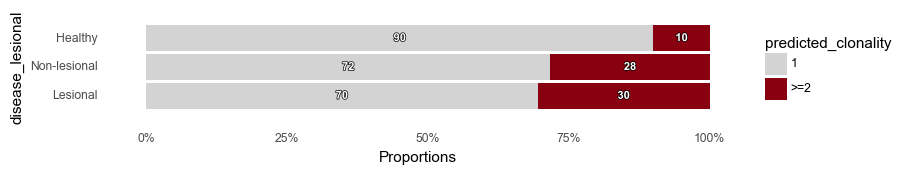

<ggplot: (8768722496756)>

In [375]:
plot_proportion_barplot(lym, 'disease_lesional', 'predicted_clonality')

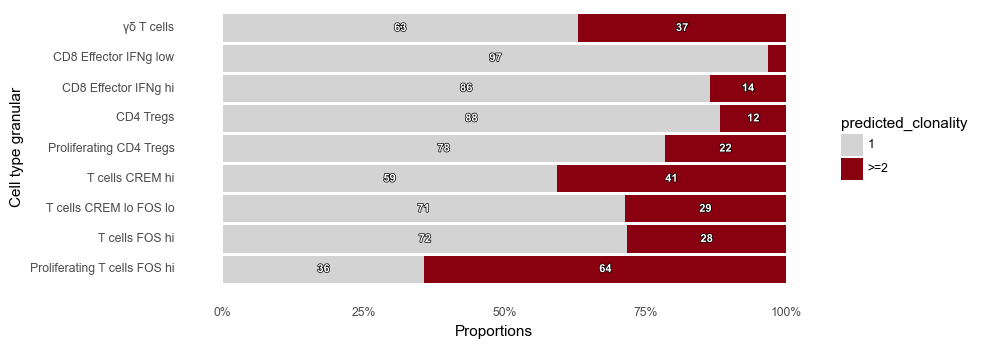

<ggplot: (8768726376346)>

In [376]:
plot_proportion_barplot(lym, 'Cell type granular', 'predicted_clonality')

In [ ]:
plot_proportion_barplot(lym, 'ind_id', 'predicted_clonality')

In [ ]:
plot_proportion_barplot(lym, 'channel', 'predicted_clonality')